In [5]:
import jax
import jax.numpy as jnp
from typing import Any
from flax import linen as nn
from jax import random, grad, vmap, jit
from pikan.model_utils import gradf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_3d_array(data, cmap='jet', interval=50):
    fig, ax = plt.subplots()
    im = ax.imshow(data[:, :, 0], cmap=cmap, origin='lower', interpolation='nearest')
    plt.colorbar(im, ax=ax)

    def update(t):
        im.set_array(data[:, :, t])
        ax.set_title(f'Time step: {t}')
    
    anim = FuncAnimation(fig, update, frames=data.shape[2], interval=interval)
    
    plt.close(fig)  # Prevent static frame from showing
    
    # Return HTML representation of the animation for embedding in Jupyter
    return HTML(anim.to_jshtml())

def load_ns_data():
    data = np.load('ns_tori.npy', allow_pickle=True).item()

    for key in data.keys() - {"viscosity"}:
        data[key] = np.moveaxis(data[key], 0, -1)

    return data['u'], data['v'], data['w'], data['x'], data['y'], data['t']

In [6]:
class NS_torus():
    def __init__(self, model, u0, v0, w0, x_star, y_star):
        self.model = model
        self.RE = 10
        
        self.r_net_fn = vmap(self.r_net, (None, 0,0,0))
        self.neural_net_fn = vmap(self.neural_net, (None, 0,0,0))
        self.w_net_fn = vmap(self.w_net, (None, 0,0,0))
        
        self.u0 = u0.reshape(-1)
        self.v0 = v0.reshape(-1)
        self.w0 = w0.reshape(-1)
        
        self.x_star = x_star.flatten()
        self.y_star = y_star.flatten()
        
    def neural_net(self, params, x, y, t):
        collocs = jnp.stack([x,y,t])
        outputs = self.model.apply(params, collocs)

        u = outputs[0]
        v = outputs[1]
        return u, v

    def u_net(self, params, x, y, t):
        u, _ = self.neural_net(params,x,y,t)
        return u
    
    def v_net(self, params, x, y, t):
        _, v = self.neural_net(params, x,y,t)
        return v

    def w_net(self, params, x, y, t):
        v_x = grad(self.v_net, argnums=1)(params,x,y,t)
        u_y = grad(self.u_net, argnums=2)(params,x,y,t)
        
        return v_x + u_y
    
    def r_net(self, params, x, y, t):
        # w_t + U * grad w - 1/Re * Laplacian w
        w_t = grad(self.w_net, argnums=3)(params,x,y,t)
        w_x = grad(self.w_net, argnums=1)(params,x,y,t)
        w_y = grad(self.w_net, argnums=2)(params,x,y,t)
        
        u, v = self.neural_net(params, x, y, t)
        
        w_xx = grad(grad(self.w_net, argnums=1), argnums=1)(params,x,y,t)
        w_yy = grad(grad(self.w_net, argnums=2), argnums=2)(params,x,y,t)
        eq1 = w_t + (u*w_x + v*w_y) - 1/self.RE * (w_xx+w_yy)
        
        # u_x + v_y = 0 eq2
        u_x = grad(self.u_net, argnums=1)(params,x,y,t)
        v_y = grad(self.v_net, argnums=2)(params,x,y,t)
        eq2 = u_x + v_y
        
        return eq1, eq2
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs): # collocs shape (BS, 3)
        t0 = jnp.zeros_like(self.x_star)
        u0,v0 = self.neural_net_fn(params, self.x_star, self.y_star, t0)
        w0 = self.w_net_fn(params, self.x_star, self.y_star, t0)
        
        u0_loss = jnp.mean((u0 - self.u0)**2)
        v0_loss = jnp.mean((v0 - self.v0)**2)
        w0_loss = jnp.mean((w0 - self.w0)**2)
        
        ic_loss = u0_loss + v0_loss + w0_loss
        
        eq1, eq2 = self.r_net_fn(params, collocs[:, 0], collocs[:, 1], collocs[:, 2])
        res_loss = jnp.mean(eq1**2) + jnp.mean(eq2**2)
        
        new_loc_w = None
        return res_loss + ic_loss, new_loc_w

In [7]:
class VelocityNet(nn.Module):
    features: Any

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for feature in self.features:
            x = nn.Dense(features=feature)(x)  # Fully connected layer
            x = nn.tanh(x)  # Activation function (tanh)
        x = nn.Dense(features=2)(x)  # Final output layer with 2 outputs (u, v)
        return x

features = [32, 32, 32]    
model = VelocityNet(features)

dp = jnp.ones(3)
params = model.init(random.PRNGKey(0), dp)

In [8]:
u,v,w,x,y,t = load_ns_data()
x_star, y_star = jnp.meshgrid(x, y)

In [10]:
ns_torus = NS_torus(
    model, 
    u[:, :, 0], v[:, :, 0], w[:, :, 0],
    x_star, y_star,
)

BS = 32
collocs = jnp.ones((BS, 3))
ns_torus.loss(params, collocs)

(Array(13.812845, dtype=float32), None)

In [11]:
import jax
import optax

# Define your gradient function
grad_fn = jax.value_and_grad(ns_torus.loss, has_aux=True)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)

# Initialize optimizer state
opt_state = optimizer.init(params)

# Define the training loop
def train_step(params, collocs, opt_state):
    # Compute loss and gradients
    (loss, new_loc_w), grads = grad_fn(params, collocs)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

# Training loop
num_epochs = 1000  # Number of training epochs
for epoch in range(num_epochs):
    # Training step
    params, opt_state, loss = train_step(params, collocs, opt_state)

    # Optionally, print the loss every 100 epochs or as needed
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 13.812845230102539
Epoch 100, Loss: 10.527444839477539
Epoch 200, Loss: 8.474397659301758
Epoch 300, Loss: 7.83220911026001
Epoch 400, Loss: 7.38948392868042
Epoch 500, Loss: 7.0353875160217285
Epoch 600, Loss: 6.373086452484131
Epoch 700, Loss: 5.527863025665283
Epoch 800, Loss: 4.952881813049316
Epoch 900, Loss: 4.446317195892334


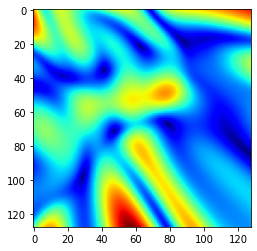

In [23]:
(u,v) = ns_torus.neural_net_fn(params, ns_torus.x_star, ns_torus.y_star, jnp.zeros_like(ns_torus.x_star))

magnitude_field = np.sqrt(u**2 + v**2).reshape((128, 128))
plt.imshow(magnitude_field, cmap="jet")

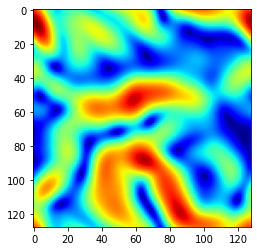

In [25]:
magnitude_field = np.sqrt(ns_torus.u0**2 + ns_torus.v0**2).reshape((128, 128))
plt.imshow(magnitude_field, cmap="jet")